In [333]:
import pandas as pd
import scipy as sc
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
import sklearn
from sklearn import linear_model, metrics, preprocessing, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.special import expit
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

At first, we added the data to our main DataDrame.
At the crawling prosses we accidentally missed some importent data which we added later with concat. 
After that, we deleted duplicates to be sure.

In [334]:
df = pd.read_csv("raw_data.csv")
tempdf = pd.read_csv("data_firsts.csv") #6860 rows × 43 columns
df = pd.concat([df,tempdf])
df = df.copy()
df = df.drop('Unnamed: 0', axis=1)

#Drop duplicated links
df.drop_duplicates(subset='Link', keep='last', inplace=True) 

# Data Handling
Beacuse we had missing parts in our data we started a Data Handling process.

We deleted rows without important data like Name and Start year.

Columns with missing data were coverd with '0', 'mean' and 'median' data.

Missing data of diffrent types of names were replced with the Romaji name which was the most common. 

Missing Genre data was coverd with "No Genre" and wasn't deleted so we won't delete a lot of our important data.

We calculated the Averege Rating by calculating the mean of all the different rating types we got from the website.

After some thoughts we decided to delet un-needed columns that won't help us with our question.

*In the machine learning process we tried to get to a better result by deleting the rows with missing genre data, but it didn't helped.
We also tried to organize the Averege Rating scores in 10 bins for the same cause. 

In [335]:
#Drop un-needed rows
df.dropna(thresh = 10, inplace = True)
df.dropna(subset = 'Name Romaji', inplace = True)
df.dropna(subset = 'Start Year', inplace = True)
df.dropna(subset = 'Status', inplace = True) 

#Fixing index col after rows delete
df = df.reset_index() 
df = df.drop('index', axis=1) 

#Filling NaN values before merging 
df['Rating 10'].fillna(0, inplace=True)
df['Rating 20'].fillna(0, inplace=True)
df['Rating 30'].fillna(0, inplace=True)
df['Rating 40'].fillna(0, inplace=True)
df['Rating 50'].fillna(0, inplace=True)
df['Rating 60'].fillna(0, inplace=True)
df['Rating 70'].fillna(0, inplace=True)
df['Rating 80'].fillna(0, inplace=True)
df['Rating 90'].fillna(0, inplace=True)
df['Rating 100'].fillna(0, inplace=True)

#Filling missing numeric values
df['Favorites'].fillna(df['Favorites'].mean(), inplace=True)
df['Rating Rank'].fillna(0, inplace=True)
df['Popularity Rank'].fillna(0, inplace=True)
df['Volume Count'].fillna(df['Volume Count'].mean(), inplace=True)
df['Popularity'].fillna(df['Popularity'].median(), inplace=True)
df['Anime Release Date'].fillna(df['Anime Release Date'].median(), inplace=True)

#Filling missing non-numeric values
df.Source = df.Source.fillna(df.Source.mode()[0])

for i in range(0, df.shape[0]):
    if df.loc[i,'Name English'] is np.nan:
        df.loc[i,'Name English'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Name Native'] is np.nan:
        df.loc[i,'Name Native'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Synonyms'] is np.nan:
        df.loc[i,'Synonyms'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Tag_One'] is np.nan:
        df.loc[i,'Tag_One'] = 'No Tag'
    if df.loc[i,'Tag_Two'] is np.nan:
        df.loc[i,'Tag_Two'] = 'No Tag'
    if df.loc[i,'Tag_Three'] is np.nan:
        df.loc[i,'Tag_Three'] = 'No Tag'
    if df.loc[i,'Genre_One'] is np.nan:
        df.loc[i,'Genre_One'] = 'No Genre'
    if df.loc[i,'Genre_Two'] is np.nan:
        df.loc[i,'Genre_Two'] = 'No Genre'
    if df.loc[i,'Genre_Three'] is np.nan:
        df.loc[i,'Genre_Three'] = 'No Genre'
        
    df['Average Rating'] = (((df['Rating 10'])*10 + (df['Rating 20'])*20 + (df['Rating 30'])*30 + (df['Rating 40'])*40 +
                            (df['Rating 50'])*50 + (df['Rating 60'])*60 + (df['Rating 70'])*70 + (df['Rating 80'])*80 +
                            (df['Rating 90'])*90 + (df['Rating 100'])*100)/((df['Rating 10']) + (df['Rating 20']) + 
                            (df['Rating 30']) + (df['Rating 40']) +(df['Rating 50']) + (df['Rating 60']) + (df['Rating 70'])
                            + (df['Rating 80']) +(df['Rating 90']) + (df['Rating 100']))) #Adding average
    
for i in range(0, df.shape[0]):
    if np.isnan(df.loc[i,'Average Rating']):
        df.loc[i,'Average Rating'] = df.loc[i,'Mean Score']
df['Average Rating'].fillna(df['Average Rating'].mean(), inplace=True)
#df.dropna(subset = 'Average Rating', inplace = True)

#Dropping unnecessary columns
df = df.drop(['Rating 10','Rating 20','Rating 30','Rating 40','Rating 50','Rating 60',
             'Rating 70','Rating 80','Rating 90','Rating 100'], axis=1)
df = df.drop('Chapter Count', axis=1)
df = df.drop('End Date', axis=1)
df = df.drop('Average Score', axis=1)
df = df.drop('Mean Score', axis=1)
df = df.drop('Related 1 Type', axis=1)
df = df.drop('Related 2 Type', axis=1)
df = df.drop('Popularity Number', axis=1)
df = df.drop('Rating Number', axis=1)
df = df.drop('Format', axis=1)

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1,2,3,4,5,6,7,8,9,10]
df['Average_Rating_binned'] = pd.cut(df['Average Rating'], bins, labels = labels)

We changed the type of the non-numeric columns to 'category' to save some space, as we learned at the course.

The "Has Anime" feature was changed to a numeric Boolean type so we coult fit it to the vector at the machine learning process.

We decided to number the names of the genres so that we could use them conveniently later in the code to analyze the data of this feature.

The 'Status' and 'Source' featurs were changed to a boolean columns for the machine learning process, to try and get a better result. 



In [336]:
#Change type to save space
df["Name Romaji"] = df["Name Romaji"].astype('category')
df["Name Native"] = df["Name Native"].astype('category')
df["Name English"] = df["Name English"].astype('category')
df["Synonyms"] = df["Synonyms"].astype('category')
df["Status"] = df["Status"].astype('category')
df["Source"] = df["Source"].astype('category')
df["Genre_One"] = df["Genre_One"].astype('category')
df["Genre_Two"] = df["Genre_Two"].astype('category')
df["Genre_Three"] = df["Genre_Three"].astype('category')
df["Tag_One"] = df["Tag_One"].astype('category')
df["Tag_Two"] = df["Tag_Two"].astype('category')
df["Tag_Three"] = df["Tag_Three"].astype('category')
df["Start Date"] = df["Start Date"].astype('category')
df["Rating Rank"] = df["Rating Rank"].astype('category')
df["Popularity Rank"] = df["Popularity Rank"].astype('category')
df["Has Anime"] = df["Has Anime"].astype('int')

replace_map_Genre = {'Drama':1, 'Adventure':2, 'Action':3, 'Comedy':4, 'Mystery':5, 'Romance':6, 'Fantasy':7,
 'Horror':8, 'Sci-Fi':9, 'Psychological':10, 'Ecchi':11, 'Supernatural':12, 'Music':13,
 'Thriller':14, 'Slice of Life':15, 'Sports':16, 'Mahou Shoujo':17, 'Mecha':18, 'No Genre':0}

df_NUM = df.copy()
df_NUM.replace(replace_map_Genre, inplace = True)

df = pd.get_dummies(df, columns=['Status'], prefix = ['Status'])
df = pd.get_dummies(df, columns=['Source'], prefix = ['Source'])

# 4078 rows × 40 columns

# Advanced Data Analysis
As the main feature for our research question, we wanted to see the ratio between the novels that have adaptation, and those that don't.

In [337]:
df['Has Anime'].value_counts(normalize=True)

0    0.850417
1    0.149583
Name: Has Anime, dtype: float64

As one of the features that interested us the most, we decided to analyze the genre feature as much as possible.

We combined the data from the three genre columns into an additional data frame in order to see which types of genres are associated with which number of books, and how many of them were adapted.

In [338]:
gen_names = ['Drama', 'Adventure', 'Action', 'Comedy', 'Mystery','Romance','Fantasy','Horror','Sci-Fi',
                'Psychological','Ecchi','Supernatural','Music','Thriller','Slice of Life','Sports','Mahou Shoujo','Mecha','No Genre']
gen_num_books = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gen_num_anime = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for g in df_NUM["Genre_One"]:
    gen_num_books[g]+= 1
    
for g2 in df_NUM["Genre_Two"]:
    gen_num_books[g2]+= 1
    
for g3 in df_NUM["Genre_Three"]:
    gen_num_books[g3]+= 1
    
    
for ai, a1 in df_NUM.iterrows():
    gen_num_anime[a1["Genre_One"]] += a1["Has Anime"]
    gen_num_anime[a1["Genre_Two"]] += a1["Has Anime"]
    gen_num_anime[a1["Genre_Three"]] += a1["Has Anime"]


gen_data = {"Genre Names":gen_names,
            "Number of Books":gen_num_books,
            "Number of Anime":gen_num_anime,
                                                }
gen_df = pd.DataFrame({'Number of Books':gen_num_books,
                       'Number of Anime':gen_num_anime},
                      index = gen_names)

gen_df = gen_df.drop(labels = ['No Genre'],axis = 0)
gen_df

,Number of Books,Number of Anime
Drama,2499,274
Adventure,822,170
Action,945,133
Comedy,1447,266
Mystery,1568,217
Romance,285,68
Fantasy,1273,134
Horror,1727,183
Sci-Fi,84,25
Psychological,232,83


For ease of placement in the machine learning process, we decided to combine the three genre columns into a new data frame, which displays in a Boolean form of 'whether this genre is associated with the book in the row'.

In [339]:
df_dummies = pd.get_dummies(df[['Genre_One', 'Genre_Two', 'Genre_Three']])

In [340]:
for genere in gen_names:
    df_dummies['is'+ genere] = df_dummies['Genre_One_'+genere] if df_dummies['Genre_One_'+genere] is not None else 0 | df_dummies['Genre_Two_'+genere] if df_dummies['Genre_Two_'+genere] is not None else 0 | df_dummies['Genre_Three_'+genere] if df_dummies['Genre_Three_'+genere] is not None else 0
    try:
        df_dummies = df_dummies.drop('Genre_One_'+genere, axis=1)
    except: next
    try:
        df_dummies = df_dummies.drop('Genre_Two_'+genere, axis=1)
    except: next
    try:
        df_dummies = df_dummies.drop('Genre_Three_'+genere, axis=1)
    except: next

In [341]:
df_dummies

,isDrama,isAdventure,isAction,isComedy,isMystery,isRomance,isFantasy,isHorror,isSci-Fi,isPsychological,isEcchi,isSupernatural,isMusic,isThriller,isSlice of Life,isSports,isMahou Shoujo,isMecha,isNo Genre
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4074,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4075,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4076,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We added the new data frame to our main data frame and deleted the un-needed old genre columns.

In [342]:
df = pd.concat([df,df_dummies], axis = 1)
df = df.drop('Genre_One', axis=1)
df = df.drop('Genre_Two', axis=1)
df = df.drop('Genre_Three', axis=1)

# Machine Learning
   ### Logistic Regression
Due to the fact that our research question is of a categorical type, and the label amounts to a "yes or no" answer, we first chose the "logistic regression" algorithm due to its suitability for this type of label with 2 results

#### Input & Feature Extractor
We created a new data frame with the features we found relevant to our research question.

During the machine learning process, in order to try and improve the result, we tried to delete features that we found to be correlated.

In [343]:
df_matrix=df[["Start Year", "Volume Count","Status_Cancelled","Status_Finished",
             "Status_Hiatus", "Status_Not Yet Released", "Source_Anime","Source_Game","Source_Light Novel",
              "Source_Live Action", "Source_Manga", "Source_Novel",
              "Average_Rating_binned",
              #"Source_Multimedia Project",
              #"Average Rating",
              #"Status_Releasing",
              "Name Word Count",
              "Source_Original", "Source_Other", "Source_Video Game", "Source_Visual Novel", "Source_Web Novel", "isDrama",
              "isAdventure","isAction", "isComedy","isMystery","isRomance","isFantasy","isHorror", "isSci-Fi", "isPsychological",
              "isSupernatural", "isMusic", "isThriller", "isSlice of Life","isSports", "isMahou Shoujo", "isMecha", "isNo Genre",
              "Has Anime"]].copy()
df_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Start Year               4078 non-null   float64 
 1   Volume Count             4078 non-null   float64 
 2   Status_Cancelled         4078 non-null   uint8   
 3   Status_Finished          4078 non-null   uint8   
 4   Status_Hiatus            4078 non-null   uint8   
 5   Status_Not Yet Released  4078 non-null   uint8   
 6   Source_Anime             4078 non-null   uint8   
 7   Source_Game              4078 non-null   uint8   
 8   Source_Light Novel       4078 non-null   uint8   
 9   Source_Live Action       4078 non-null   uint8   
 10  Source_Manga             4078 non-null   uint8   
 11  Source_Novel             4078 non-null   uint8   
 12  Average_Rating_binned    4078 non-null   category
 13  Name Word Count          4078 non-null   float64 
 14  Source_O

#### Feature Vector
For the training process we split our data to 'Training Features' and 'Target Feature' and named them 'X' and 'y' 

In [344]:
TRAINING_FEATURES = df_matrix.columns[df_matrix.columns != 'Has Anime']
TARGET_FEATURE = 'Has Anime'
X = df_matrix[TRAINING_FEATURES]
y = df_matrix[TARGET_FEATURE]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Has Anime, dtype: int32

#### Machine Learning Algorithm
We split our data into four variables according to training and test, in a ratio of 70% to training and 30% to test and presented our data again

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
print("Initial amount of samples: #{}".format(X.shape[0]))
print("Number of training samples: #{}".format(X_train.shape[0]))
print("Number of test samples: #{}".format(X_test.shape[0]))
print("\nTarget distribution in original dataset:\n{}".format(y.value_counts()))
print("\nTarget distribution in the training set:\n{}\n".format(y_train.value_counts()))
print("Target distribution in the test set:\n{}".format(y_test.value_counts()))

Initial amount of samples: #4078
Number of training samples: #2854
Number of test samples: #1224

Target distribution in original dataset:
0    3468
1     610
Name: Has Anime, dtype: int64

Target distribution in the training set:
0    2435
1     419
Name: Has Anime, dtype: int64

Target distribution in the test set:
0    1033
1     191
Name: Has Anime, dtype: int64


We scaled our variables and saw the result

In [346]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print("Mean: ", X_train_scaled.mean(axis=0))
print("Standard Deviation: ", X_train_scaled.std(axis=0))

Mean:  [-5.43363532e-15 -2.98756581e-17 -3.73445727e-18 -1.04564803e-16
 -1.30706004e-17 -4.97927635e-18 -3.11204772e-17  4.97927635e-18
 -1.74274672e-17  2.48963818e-18  3.48549345e-17  4.97927635e-18
 -2.60167190e-16 -7.34443262e-17 -1.78009130e-16  4.35686681e-18
 -2.61412009e-17  1.74274672e-17  0.00000000e+00  4.97927635e-18
 -6.09961353e-17  2.86308390e-17  2.30291531e-17 -8.71373362e-18
 -6.22409544e-18 -6.03737258e-17 -9.95855271e-18 -4.97927635e-18
  1.24481909e-17 -1.86722863e-17 -1.99171054e-17  9.95855271e-18
 -4.97927635e-18 -2.61412009e-17 -1.61826482e-17 -3.11204772e-17
 -6.22409544e-17]
Standard Deviation:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [347]:
X_test_scaled = scaler.transform(X_test)
print("Mean: ", X_test_scaled.mean(axis=0))
print("Standard Deviation: ", X_test_scaled.std(axis=0))

Mean:  [-0.01585664  0.01767581  0.00372365 -0.00210789  0.02333809 -0.03493997
  0.00682905  0.0249319  -0.04167897 -0.01872187 -0.00595204  0.15589318
 -0.00675124 -0.05223489 -0.00471479  0.02087687 -0.05070894  0.05534878
 -0.01252941  0.02738878  0.01521107 -0.04450412  0.00427118  0.01105137
 -0.00873688  0.00050273  0.03503172 -0.04785828 -0.02235649  0.10221579
  0.00515245 -0.02648136  0.00640573  0.02805166  0.06613849 -0.00184924
  0.05996951]
Standard Deviation:  [1.00169871e+00 1.05914521e+00 1.02937741e+00 1.00053904e+00
 1.15335006e+00 7.41700093e-01 1.02124385e+00 1.52663387e+00
 7.01825478e-01 0.00000000e+00 9.82197252e-01 3.04952063e+00
 1.10469543e+00 9.48189268e-01 1.00605527e+00 1.09704162e+00
 7.95048306e-01 1.21670762e+00 8.81918840e-01 1.04042267e+00
 1.02392902e+00 9.86057475e-01 1.00262126e+00 1.03285794e+00
 9.80199505e-01 1.00062910e+00 1.22280937e+00 6.67804786e-01
 6.83210532e-01 1.57914482e+00 1.03720482e+00 3.46944695e-18
 1.04289007e+00 1.32171733e+00 1

In [348]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_in_range = min_max_scaler.fit_transform(X_train)
print("Min Value: ", X_train_scaled_in_range.min(axis=0))
print("Max Value: ", X_train_scaled_in_range.max(axis=0))
X_test_scaled_in_range = min_max_scaler.transform(X_test)

Min Value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max Value:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [349]:
clf_model = LogisticRegression().fit(X_train, y_train)
y_pred=clf_model.predict(X_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model
After the logistic regression algorithm we built a table that consolidates the predicted result and the real result with another col pointing our correct predictions

In [350]:
resDF=pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
resDF["correct"]=abs((resDF["Actual"]^resDF["Predicted"])-1)
resDF[resDF["correct"]==1]
resDF

,Actual,Predicted,correct
2676,0,0,1
2312,0,0,1
3548,0,0,1
3931,0,0,1
1827,0,0,1
...,...,...,...
3984,1,0,0
2950,0,0,1
373,1,0,0
1331,0,0,1


In [351]:
resDF['Actual'].value_counts()

0    1033
1     191
Name: Actual, dtype: int64

In [352]:
resDF['Predicted'].value_counts()

0    1126
1      98
Name: Predicted, dtype: int64

In [353]:
resDF['correct'].value_counts()

1    1079
0     145
Name: correct, dtype: int64

We bulid a confusion matrix so see the results better


The matrix shows us the predicted true ,the actual true, the predicted false and the actual false

In [354]:
y_pred = resDF['Predicted']
y_actual = resDF['Actual']
matrix = metrics.confusion_matrix(y_actual, y_pred)

In [355]:
confusionDF = pd.DataFrame(matrix)
confusionDF.index = ["Actual False" , "Actual True"]
confusionDF.columns = ["Predicted False" , "Predicted True"]
confusionDF

,Predicted False,Predicted True
Actual False,1007,26
Actual True,119,72


We checked the accuracy and the F1 to check how well the algorithm worked in predicting the question

#### Evaluation

In [356]:
print("accuracy is:",metrics.accuracy_score(y_actual, y_pred))  
print("precision is:",metrics.precision_score(y_actual, y_pred))
print("recall is:",metrics.recall_score(y_actual, y_pred))
print("f1 is:",metrics.f1_score(y_actual, y_pred))
print("r2 is:",metrics.r2_score(y_actual, y_pred))

accuracy is: 0.8815359477124183
precision is: 0.7346938775510204
recall is: 0.3769633507853403
f1 is: 0.4982698961937716
r2 is: 0.10046983573488488


#### Correlation test to get a better result

At the stage of evaluating the results, we saw that the result was not satisfactory.

We tried to improve it with a change in the type and layout of different characteristics, a different treatment of deficiencies and outliers and we even placed the different characteristics that we placed in the algorithm in a heat table in order to observe the correlation between different characteristics in order to try to find how to improve the result

C:\Users\Mor\AppData\Local\Temp\ipykernel_8732\1614715046.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_matrix.corr().style.background_gradient(cmap, axis=1)\


,Start Year,Volume Count,Status_Cancelled,Status_Finished,Status_Hiatus,Status_Not Yet Released,Source_Anime,Source_Game,Source_Light Novel,Source_Live Action,Source_Manga,Source_Novel,Name Word Count,Source_Original,Source_Other,Source_Video Game,Source_Visual Novel,Source_Web Novel,isDrama,isAdventure,isAction,isComedy,isMystery,isRomance,isFantasy,isHorror,isSci-Fi,isPsychological,isSupernatural,isMusic,isThriller,isSlice of Life,isSports,isMahou Shoujo,isMecha,isNo Genre,Has Anime
Start Year,1.00,-0.18,0.00,-0.46,-0.03,0.10,-0.14,-0.01,-0.00,-0.04,-0.06,0.02,0.41,0.14,0.03,-0.06,-0.08,0.05,-0.09,0.06,-0.06,0.07,-0.08,0.05,0.08,-0.06,-0.05,-0.00,-0.01,0.00,-0.03,0.02,0.00,-0.01,-0.14,0.00,-0.33
Volume Count,-0.18,1.00,0.02,-0.01,-0.00,-0.00,-0.06,0.01,-0.02,-0.01,-0.08,-0.02,-0.07,0.14,-0.05,-0.06,-0.04,-0.00,-0.09,0.03,0.08,0.04,-0.05,-0.09,-0.01,-0.01,-0.01,-0.02,-0.02,-0.04,0.00,-0.03,0.01,-0.01,-0.00,0.01,0.29
Status_Cancelled,0.00,0.02,1.00,-0.08,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,-0.01,0.02,-0.01,-0.01,-0.01,-0.00,-0.00,0.03,0.01,0.00,-0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00
Status_Finished,-0.46,-0.01,-0.08,1.00,-0.09,-0.09,0.12,0.02,0.04,0.01,0.11,0.03,-0.34,-0.19,0.02,0.07,0.08,-0.06,0.10,-0.12,-0.03,-0.01,0.09,0.08,-0.07,0.04,0.04,0.02,0.02,0.03,0.02,0.02,-0.00,0.03,0.04,-0.03,0.14
Status_Hiatus,-0.03,-0.00,-0.00,-0.09,1.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.00,-0.03,0.00,-0.01,-0.01,0.02,-0.00,-0.01,-0.02,0.02,-0.01,0.01,-0.02,0.02,0.04,-0.01,0.08,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,0.06
Status_Not Yet Released,0.10,-0.00,-0.00,-0.09,-0.01,1.00,-0.01,-0.00,-0.01,-0.00,-0.01,-0.00,0.01,0.02,-0.01,-0.01,-0.01,-0.00,-0.01,0.02,-0.02,-0.02,0.01,0.09,-0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,0.04,-0.00,-0.00,-0.00,-0.01,-0.03
Source_Anime,-0.14,-0.06,-0.01,0.12,-0.01,-0.01,1.00,-0.00,-0.01,-0.00,-0.03,-0.01,-0.08,-0.46,-0.02,-0.02,-0.02,-0.01,0.02,-0.02,0.07,-0.05,-0.01,-0.03,-0.05,-0.01,0.03,-0.01,-0.01,-0.01,-0.00,0.03,-0.01,0.13,0.04,0.01,0.35
Source_Game,-0.01,0.01,-0.00,0.02,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.02,-0.06,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,0.03,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.05
Source_Light Novel,-0.00,-0.02,-0.00,0.04,-0.01,-0.01,-0.01,-0.00,1.00,-0.00,-0.01,-0.00,-0.01,-0.22,-0.01,-0.01,-0.01,-0.00,0.00,-0.01,-0.00,-0.00,-0.01,0.03,-0.01,0.04,-0.01,-0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,0.02,0.01
Source_Live Action,-0.04,-0.01,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.02,-0.05,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.24,-0.00,0.04


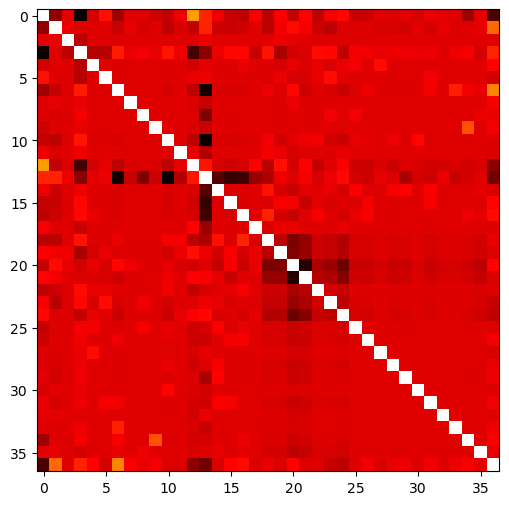

In [357]:
plt.imshow(df_matrix.corr(),cmap='hot',interpolation='nearest')

cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

df_matrix.corr().style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation between features")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [358]:
df_cor = df_matrix.corr()

In [359]:
for row in range(36):
    for col in range(36):
        if (df_cor.iloc[row,col] > abs(0.3) and df_cor.iloc[row,col] != 1 ):
            print(df_cor.index[row] ," : ",df_cor.columns[col] , " : ",df_cor.iloc[row,col])

Start Year  :  Name Word Count  :  0.40706413031730065
Name Word Count  :  Start Year  :  0.40706413031730065


In [360]:
clf_model.predict(X_train_scaled)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [361]:
clf_model.score(X_train_scaled, y_train)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.7589348283111422

In [362]:
clf_model.score(X_test_scaled, y_test)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.7459150326797386

### Random Forest
We tried to switch to another suitable algorithm - Random Forest, an algorithm that uses decision trees and combines many simple trees together and generalizes the results of the trees and thus reaches a fairly high accuracy in the classification results

#### Input & Feature Extractor

In [363]:
df_matrix_FOREST=df[["Start Year", "Volume Count","Status_Cancelled","Status_Finished",
             "Status_Hiatus", "Status_Not Yet Released", "Source_Anime","Source_Game","Source_Light Novel",
              "Source_Live Action", "Source_Manga", "Source_Novel",
              #"Average_Rating_binned",
              #"Source_Multimedia Project",
              "Average Rating",
              "Name Word Count","Status_Releasing",
              "Source_Original", "Source_Other", "Source_Video Game", "Source_Visual Novel", "Source_Web Novel", "isDrama",
              "isAdventure","isAction", "isComedy","isMystery","isRomance","isFantasy","isHorror", "isSci-Fi", "isPsychological",
              "isSupernatural", "isMusic", "isThriller", "isSlice of Life","isSports", "isMahou Shoujo", "isMecha", "isNo Genre",
              "Has Anime"]].copy()

#### Feature Vector

In [364]:
TRAINING_FEATURES_FOREST = df_matrix_FOREST.columns[df_matrix_FOREST.columns != 'Has Anime']
TARGET_FEATURE_FOREST = 'Has Anime'
X_F = df_matrix_FOREST[TRAINING_FEATURES_FOREST]
y_F = df_matrix_FOREST[TARGET_FEATURE_FOREST]
y_F.head()

0    0
1    0
2    0
3    0
4    0
Name: Has Anime, dtype: int32

#### Machine Learning Algorithm

In [365]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_F, y_F, test_size=0.3, random_state=52)
print("Initial amount of samples: #{}".format(X_F.shape[0]))
print("Number of training samples: #{}".format(X_train_F.shape[0]))
print("Number of test samples: #{}".format(X_test_F.shape[0]))
print("\nTarget distribution in original dataset:\n{}".format(y_F.value_counts()))
print("\nTarget distribution in the training set:\n{}\n".format(y_train_F.value_counts()))
print("Target distribution in the test set:\n{}".format(y_test_F.value_counts()))

Initial amount of samples: #4078
Number of training samples: #2854
Number of test samples: #1224

Target distribution in original dataset:
0    3468
1     610
Name: Has Anime, dtype: int64

Target distribution in the training set:
0    2424
1     430
Name: Has Anime, dtype: int64

Target distribution in the test set:
0    1044
1     180
Name: Has Anime, dtype: int64


#### Looking for the number of estimators that will give us the best result

<AxesSubplot:xlabel='Number of Estimates', ylabel='Accuracy Score'>

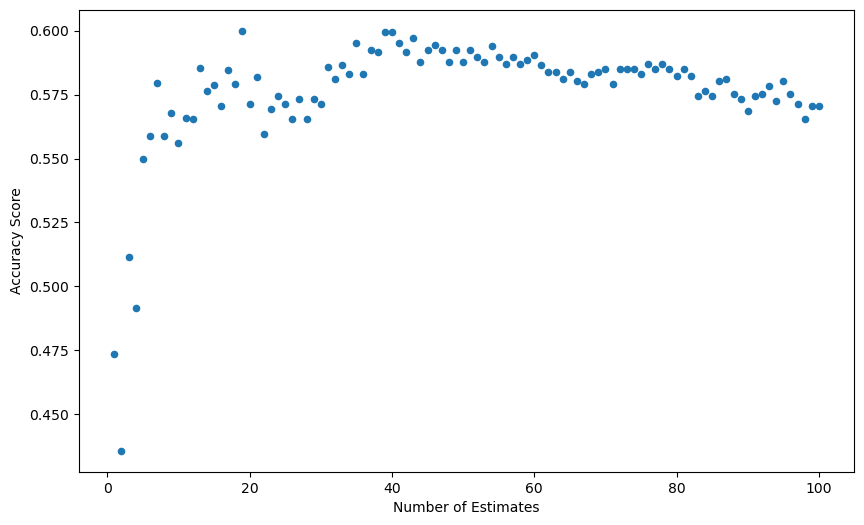

In [366]:
rf_est = []
rf_res = []
f1_max = 0
for i in range(1,101):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train_F, y_train_F)
    y_pred_F = rf.predict(X_test_F)
    rf_est.append(i)
    rf_res.append(f1_score(y_test_F, y_pred_F))
    rfdef = pd.DataFrame({"Number of Estimates":rf_est,"Accuracy Score":rf_res})
    if((f1_score(y_test_F, y_pred_F)) > f1_max):
        f1_max = (f1_score(y_test_F, y_pred_F))
        f1_index = i
    
rf = RandomForestClassifier(n_estimators=f1_index, random_state=42)
rf.fit(X_train_F, y_train_F)

rfdef.plot.scatter("Number of Estimates","Accuracy Score")

#### Evaluation

We tried to improve the result better by treating the correlations between the characteristics, changing the distribution ratio between the training and the test, and changing the random_state and finally, we managed to reach a satisfactory result

In [367]:
print('Accuracy is:', accuracy_score(y_test_F, y_pred_F))
print('f1 is:', f1_max) #0.5086206896551724

Accuracy is: 0.8978758169934641
f1 is: 0.6


In [368]:
scaler_F = StandardScaler()
X_train_scaled_F = scaler_F.fit_transform(X_train_F)
X_test_scaled_F = scaler_F.transform(X_test_F)

In [369]:
rf.predict(X_train_scaled_F)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [370]:
rf.score(X_train_scaled_F, y_train_F)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8682550805886475

In [371]:
rf.score(X_test_scaled_F, y_test_F)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8758169934640523